In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report, 
                            RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import xgboost as xgb
import lightgbm as lgb
import shap
import warnings
warnings.filterwarnings('ignore')


In [37]:
# DATA LOADING AND INITIAL EXPLORATION 
print("Loading dataset...")
df = pd.read_csv(r"C:\Users\smitt\Desktop\Dissertation\Dissertation Submission\Final_YoY.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# VISUALIZATION SETUP
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
%matplotlib inline

Loading dataset...
Dataset shape: (5000, 75)

Columns: ['Identifier (RIC)', 'Company_Name', 'TRBC Economic Sector Name', 'Company Market Capitalization (USD)', 'Altman_Z_Score_FY0', 'Altman_Z_Score_FY-1', 'Altman_Z_Score_FY-2', 'Altman_Z_Score_FY-3', 'M_Score_FY0_vs_FY1', 'M_Score_FY1_vs_FY2', 'M_Score_FY2_vs_FY3', 'Working Capital to Total Assets (FY0)', 'Retained Earnings - Total to Total Assets (FY0)', 'Earnings before Interest & Taxes (EBIT) to Total Assets (FY0)', 'Return on Average Total Assets - % (FY0)', 'Working Capital to Total Assets (FY-1)', 'Retained Earnings - Total to Total Assets (FY-1)', 'Earnings before Interest & Taxes (EBIT) to Total Assets (FY-1)', 'Return on Average Total Assets - % (FY-1)', 'Working Capital to Total Assets (FY-2)', 'Retained Earnings - Total to Total Assets (FY-2)', 'Earnings before Interest & Taxes (EBIT) to Total Assets (FY-2)', 'Return on Average Total Assets - % (FY-2)', 'Working Capital to Total Assets (FY-3)', 'Retained Earnings - Total to 

In [38]:
# COLUMN STANDARDIZATION
def rename_columns(df):
    """
    Standardize column names for easier handling and consistency
    Maps verbose column names to concise, standardized versions
    """
    column_mapping = {
        # Company identifiers and metadata
        'Identifier (RIC)': 'ric',
        'Company_Name': 'company_name',
        'TRBC Economic Sector Name': 'sector',
        'Company Market Capitalization (USD)': 'market_cap',
        
        # Altman Z-Scores across fiscal years
        'Altman_Z_Score_FY0': 'z_score_0',
        'Altman_Z_Score_FY-1': 'z_score_1',
        'Altman_Z_Score_FY-2': 'z_score_2',
        'Altman_Z_Score_FY-3': 'z_score_3',
        
        # M-Scores and manipulation indicators
        'M_Score_FY0_vs_FY1': 'm_score_0',
        'Manipulation_Risk_FY0_vs_FY1': 'manip_risk_0',
        'M_Score_FY1_vs_FY2': 'm_score_1',
        'Manipulation_Risk_FY1_vs_FY2': 'manip_risk_1',
        'M_Score_FY2_vs_FY3': 'm_score_2',
        'Manipulation_Risk_FY2_vs_FY3': 'manip_risk_2',
        
        # Working capital ratios
        'Working Capital to Total Assets (FY0)': 'wc_ta_0',
        'Working Capital to Total Assets (FY-1)': 'wc_ta_1',
        'Working Capital to Total Assets (FY-2)': 'wc_ta_2',
        'Working Capital to Total Assets (FY-3)': 'wc_ta_3',
        
        # Retained earnings ratios
        'Retained Earnings - Total to Total Assets (FY0)': 're_ta_0',
        'Retained Earnings - Total to Total Assets (FY-1)': 're_ta_1',
        'Retained Earnings - Total to Total Assets (FY-2)': 're_ta_2',
        'Retained Earnings - Total to Total Assets (FY-3)': 're_ta_3',
        
        # Profitability measures
        'Earnings before Interest & Taxes (EBIT) to Total Assets (FY0)': 'ebit_ta_0',
        'Earnings before Interest & Taxes (EBIT) to Total Assets (FY-1)': 'ebit_ta_1',
        'Earnings before Interest & Taxes (EBIT) to Total Assets (FY-2)': 'ebit_ta_2',
        'Earnings before Interest & Taxes (EBIT) to Total Assets (FY-3)': 'ebit_ta_3',
        
        'Return on Average Total Assets - % (FY0)': 'roa_avg_0',
        'Return on Average Total Assets - % (FY-1)': 'roa_avg_1',
        'Return on Average Total Assets - % (FY-2)': 'roa_avg_2',
        'Return on Average Total Assets - % (FY-3)': 'roa_avg_3',
        
        'Return On Assets - Actual (FY0)': 'roa_act_0',
        'Return On Assets - Actual (FY-1)': 'roa_act_1',
        'Return On Assets - Actual (FY-2)': 'roa_act_2',
        'Return On Assets - Actual (FY-3)': 'roa_act_3',
        
        'Return On Equity - Actual (FY0)': 'roe_act_0',
        'Return On Equity - Actual (FY-1)': 'roe_act_1',
        'Return On Equity - Actual (FY-2)': 'roe_act_2',
        'Return On Equity - Actual (FY-3)': 'roe_act_3',
        
        # Leverage ratios
        'Net Debt to Total Capital (FY0)': 'debt_cap_0',
        'Net Debt to Total Capital (FY-1)': 'debt_cap_1',
        'Net Debt to Total Capital (FY-2)': 'debt_cap_2',
        'Net Debt to Total Capital (FY-3)': 'debt_cap_3',
        
        # Efficiency ratios
        'Asset Turnover (FY0)': 'asset_turn_0',
        'Asset Turnover (FY-1)': 'asset_turn_1',
        'Asset Turnover (FY-2)': 'asset_turn_2',
        'Asset Turnover (FY-3)': 'asset_turn_3',
        
        # Liquidity measures
        'Current Ratio (FY0)': 'current_ratio_0',
        'Current Ratio (FY-1)': 'current_ratio_1',
        'Current Ratio (FY-2)': 'current_ratio_2',
        'Current Ratio (FY-3)': 'current_ratio_3',
        
        'Interest Coverage Ratio (FY0)': 'int_cov_0',
        'Interest Coverage Ratio (FY-1)': 'int_cov_1',
        'Interest Coverage Ratio (FY-2)': 'int_cov_2',
        'Interest Coverage Ratio (FY-3)': 'int_cov_3',
        
        'Quick Ratio (FY0)': 'quick_ratio_0',
        'Quick Ratio (FY-1)': 'quick_ratio_1',
        'Quick Ratio (FY-2)': 'quick_ratio_2',
        'Quick Ratio (FY-3)': 'quick_ratio_3',
        
        'Inventory Turnover (FY0)': 'inv_turn_0',
        'Inventory Turnover (FY-1)': 'inv_turn_1',
        'Inventory Turnover (FY-2)': 'inv_turn_2',
        'Inventory Turnover (FY-3)': 'inv_turn_3',
        
        # Valuation metrics
        'PE Growth Ratio (FY0)': 'pe_growth_0',
        'PE Growth Ratio (FY-1)': 'pe_growth_1',
        'PE Growth Ratio (FY-2)': 'pe_growth_2',
        'PE Growth Ratio (FY-3)': 'pe_growth_3',
        
        # Cash flow and debt measures
        'Net Cash Flow from Operating Activities (FY0, USD)': 'cfo_0',
        'Net Cash Flow from Operating Activities (FY-1, USD)': 'cfo_1',
        'Net Cash Flow from Operating Activities (FY-2, USD)': 'cfo_2',
        'Net Cash Flow from Operating Activities (FY-3, USD)': 'cfo_3',
        
        'Debt - Total (FY0, USD)': 'debt_0',
        'Debt - Total (FY-1, USD)': 'debt_1',
        'Debt - Total (FY-2, USD)': 'debt_2',
        'Debt - Total (FY-3, USD)': 'debt_3',
        
        # Target variables
        'Overall_Audit_fraud_risk_FY0': 'target_0',
        'Overall_Audit_fraud_risk_FY1': 'target_1',
        'Overall_Audit_fraud_risk_FY2': 'target_2',
        'Overall_Audit_fraud_risk_FY3': 'target_3'
    }
    
    return df.rename(columns=column_mapping)

# Apply column standardization
df = rename_columns(df)
print("Columns after standardization:")
print(df.columns.tolist())

Columns after standardization:
['ric', 'company_name', 'sector', 'market_cap', 'z_score_0', 'z_score_1', 'z_score_2', 'z_score_3', 'm_score_0', 'm_score_1', 'm_score_2', 'wc_ta_0', 're_ta_0', 'ebit_ta_0', 'roa_avg_0', 'wc_ta_1', 're_ta_1', 'ebit_ta_1', 'roa_avg_1', 'wc_ta_2', 're_ta_2', 'ebit_ta_2', 'roa_avg_2', 'wc_ta_3', 're_ta_3', 'ebit_ta_3', 'roa_avg_3', 'roa_act_0', 'roe_act_0', 'debt_cap_0', 'asset_turn_0', 'current_ratio_0', 'int_cov_0', 'quick_ratio_0', 'inv_turn_0', 'pe_growth_0', 'cfo_0', 'roa_act_1', 'roe_act_1', 'debt_cap_1', 'asset_turn_1', 'current_ratio_1', 'int_cov_1', 'quick_ratio_1', 'inv_turn_1', 'pe_growth_1', 'cfo_1', 'roa_act_2', 'roe_act_2', 'debt_cap_2', 'asset_turn_2', 'current_ratio_2', 'int_cov_2', 'quick_ratio_2', 'inv_turn_2', 'pe_growth_2', 'cfo_2', 'roa_act_3', 'roe_act_3', 'debt_cap_3', 'asset_turn_3', 'current_ratio_3', 'int_cov_3', 'quick_ratio_3', 'inv_turn_3', 'pe_growth_3', 'cfo_3', 'debt_0', 'debt_1', 'debt_2', 'debt_3', 'target_0', 'target_1', 't

In [39]:
# DATA RESTRUCTURING
def restructure_to_panel_format(df):
    """
    Transform wide-format financial data to long panel format
    Creates a time-series structure with annual observations per company
    """
    panel_data = []
    
    # Process each fiscal year
    for year_suffix in [0, 1, 2, 3]:
        year_data = df[['ric', 'company_name', 'sector', 'market_cap']].copy()
        year_data['year'] = year_suffix
        
        # Extract year-specific features
        for col in df.columns:
            if col.endswith(f'_{year_suffix}'):
                base_col_name = col.rsplit('_', 1)[0]  # Remove year suffix
                year_data[base_col_name] = df[col]
        
        # Add target variable for corresponding year
        target_col = f'target_{year_suffix}'
        if target_col in df.columns:
            year_data['target'] = df[target_col]
        
        panel_data.append(year_data)
    
    # Combine all years into single panel
    panel_df = pd.concat(panel_data, ignore_index=True)
    
    # Sort by company and year
    panel_df = panel_df.sort_values(['ric', 'year'])
    
    return panel_df

# Restructure data
panel_df = restructure_to_panel_format(df)
print(f"Panel data shape: {panel_df.shape}")
print(f"Unique companies: {panel_df['ric'].nunique()}")


Panel data shape: (20000, 23)
Unique companies: 5000


In [40]:
# TEMPORAL FEATURE ENGINEERING
def create_temporal_features(df, company_id_col='ric'):
    """
    Generate time-based features including:
    - Lagged values (1-year)
    - Growth rates
    - Volatility measures
    - Trend indicators
    """
    # Ensure proper temporal ordering
    df = df.sort_values([company_id_col, 'year'])
    
    # Group by company for temporal operations
    grouped = df.groupby(company_id_col)
    
    # Financial ratios for feature engineering
    financial_ratios = [
        'z_score', 'm_score', 'manip_risk', 'wc_ta', 're_ta', 'ebit_ta',
        'roa_avg', 'roa_act', 'roe_act', 'debt_cap', 'asset_turn', 'current_ratio',
        'int_cov', 'quick_ratio', 'inv_turn', 'pe_growth', 'cfo', 'debt'
    ]
    
    # Filter to existing ratios only
    existing_ratios = [ratio for ratio in financial_ratios if ratio in df.columns]
    
    # Create lagged features and growth rates
    for ratio in existing_ratios:
        df[f'{ratio}_lag1'] = grouped[ratio].shift(1)
        # Calculate growth rate with protection against division by zero
        df[f'{ratio}_growth'] = (df[ratio] - df[f'{ratio}_lag1']) / (df[f'{ratio}_lag1'].abs() + 1e-6)
    
    # Create volatility measures (3-year rolling std)
    for ratio in ['roa_act', 'roe_act', 'debt_cap', 'current_ratio']:
        if ratio in df.columns:
            df[f'{ratio}_volatility'] = grouped[ratio].rolling(3, min_periods=2).std().values
    
    # Create trend indicators (3-year rolling mean)
    for ratio in ['z_score', 'roa_act', 'current_ratio']:
        if ratio in df.columns:
            df[f'{ratio}_trend'] = grouped[ratio].rolling(3, min_periods=2).mean().values
    
    # Create composite financial ratios
    if all(col in df.columns for col in ['cfo', 'debt']):
        df['cfo_to_debt'] = df['cfo'] / (df['debt'] + 1e-6)
    
    if all(col in df.columns for col in ['ebit_ta', 'debt_cap']):
        df['ebit_debt_ratio'] = df['ebit_ta'] / (df['debt_cap'] + 1e-6)
    
    return df

# Apply temporal feature engineering
panel_df = create_temporal_features(panel_df)


Dropped 0 columns with >50.0% missing values
Applying Winsorization to handle outliers...
  market_cap: Capped 200 values at lower bound (98161360.8000) and 200 values at upper bound (248099999999.9840)
  z_score: Capped 200 values at lower bound (0.0191) and 200 values at upper bound (19.3619)
  m_score: Capped 199 values at lower bound (-10.1093) and 199 values at upper bound (3.8940)
  wc_ta: Capped 200 values at lower bound (-0.2533) and 200 values at upper bound (0.6007)
  re_ta: Capped 200 values at lower bound (-0.8402) and 200 values at upper bound (0.9374)
  ebit_ta: Capped 200 values at lower bound (-0.1155) and 200 values at upper bound (0.3434)
  roa_avg: Capped 200 values at lower bound (-0.1635) and 200 values at upper bound (0.2750)
  roa_act: Capped 200 values at lower bound (-0.1023) and 200 values at upper bound (0.2617)
  roe_act: Capped 199 values at lower bound (-1.1529) and 200 values at upper bound (1.2317)
  debt_cap: Capped 200 values at lower bound (-0.8564) a

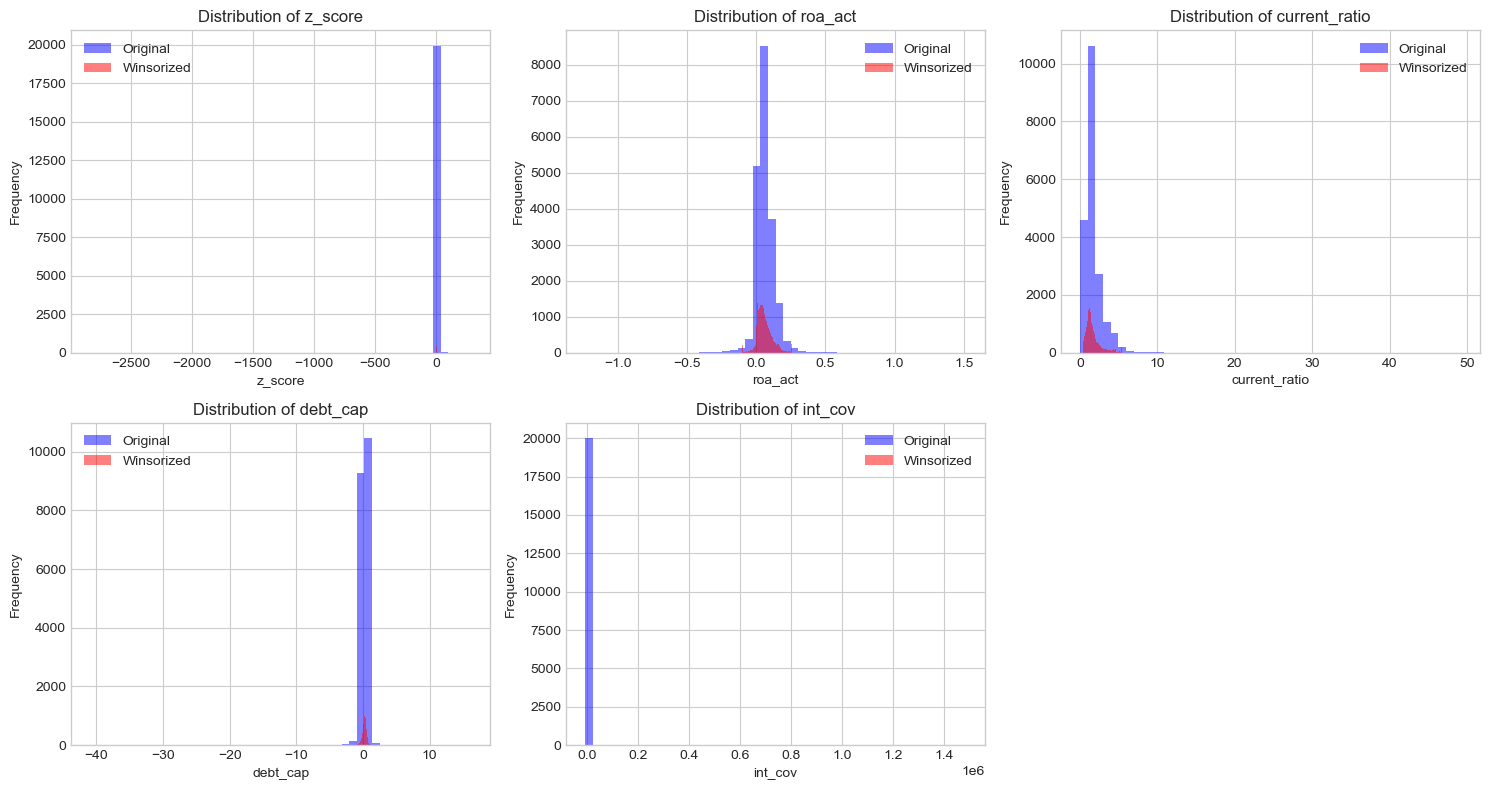

In [41]:
# MISSING DATA HANDLING WITH WINSORIZATION
def handle_missing_data(df, max_missing_percentage=0.5, winsorize_quantiles=(0.01, 0.99)):
    
    # Calculate missing percentage for each column
    missing_percent = df.isnull().mean()
    
    # Drop columns with excessive missing values
    columns_to_drop = missing_percent[missing_percent > max_missing_percentage].index
    df = df.drop(columns=columns_to_drop)
    print(f"Dropped {len(columns_to_drop)} columns with >{max_missing_percentage*100}% missing values")
    
    # Separate numeric and categorical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Time-aware imputation (forward fill within companies)
    df_sorted = df.sort_values(['ric', 'year'])
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df.groupby('ric')[col].transform(
                lambda x: x.ffill().bfill()
            )
    
    # KNN imputation for remaining missing numeric values
    imputer = KNNImputer(n_neighbors=5)
    numeric_data = df[numeric_cols]
    imputed_numeric = imputer.fit_transform(numeric_data)
    df[numeric_cols] = imputed_numeric
    
    # Apply Winsorization to handle outliers
    if winsorize_quantiles:
        print("Applying Winsorization to handle outliers...")
        df = winsorize_data(df, numeric_cols, winsorize_quantiles)
    
    # Mode imputation for categorical columns
    for col in categorical_cols:
        if col in df.columns and df[col].isnull().any():
            mode_val = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
            df[col].fillna(mode_val, inplace=True)
    
    return df

def winsorize_data(df, numeric_cols, quantiles=(0.01, 0.99)):
    
    df_winsorized = df.copy()
    
    for col in numeric_cols:
        if col in df.columns:
            # Calculate lower and upper bounds
            lower_bound = df[col].quantile(quantiles[0])
            upper_bound = df[col].quantile(quantiles[1])
            
            # Cap values at bounds
            df_winsorized[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
            
            # Report capping statistics
            n_capped_lower = (df[col] < lower_bound).sum()
            n_capped_upper = (df[col] > upper_bound).sum()
            
            if n_capped_lower > 0 or n_capped_upper > 0:
                print(f"  {col}: Capped {n_capped_lower} values at lower bound ({lower_bound:.4f}) "
                      f"and {n_capped_upper} values at upper bound ({upper_bound:.4f})")
    
    return df_winsorized

# Create pre-Winsorization copy for comparison
panel_df_before_winsorization = panel_df.copy()

# Apply enhanced missing data handling
panel_df = handle_missing_data(panel_df, winsorize_quantiles=(0.01, 0.99))

# %%
# --- WINSORIZATION VISUALIZATION ---
def visualize_winsorization_effect(df, before_df, columns_to_plot, n_cols=3):
    
    n_rows = int(np.ceil(len(columns_to_plot) / n_cols))
    
    plt.figure(figsize=(5 * n_cols, 4 * n_rows))
    
    for i, col in enumerate(columns_to_plot, 1):
        if col in df.columns and col in before_df.columns:
            plt.subplot(n_rows, n_cols, i)
            
            # Plot distributions
            plt.hist(before_df[col].dropna(), bins=50, alpha=0.5, label='Original', color='blue')
            plt.hist(df[col].dropna(), bins=50, alpha=0.5, label='Winsorized', color='red')
            
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.legend()
    
    plt.tight_layout()
    plt.show()

# Visualize effect on key financial ratios
key_ratios = ['z_score', 'roa_act', 'current_ratio', 'debt_cap', 'int_cov']
key_ratios = [ratio for ratio in key_ratios if ratio in panel_df.columns]

visualize_winsorization_effect(panel_df, panel_df_before_winsorization, key_ratios)


=== EXPLORATORY DATA ANALYSIS ===



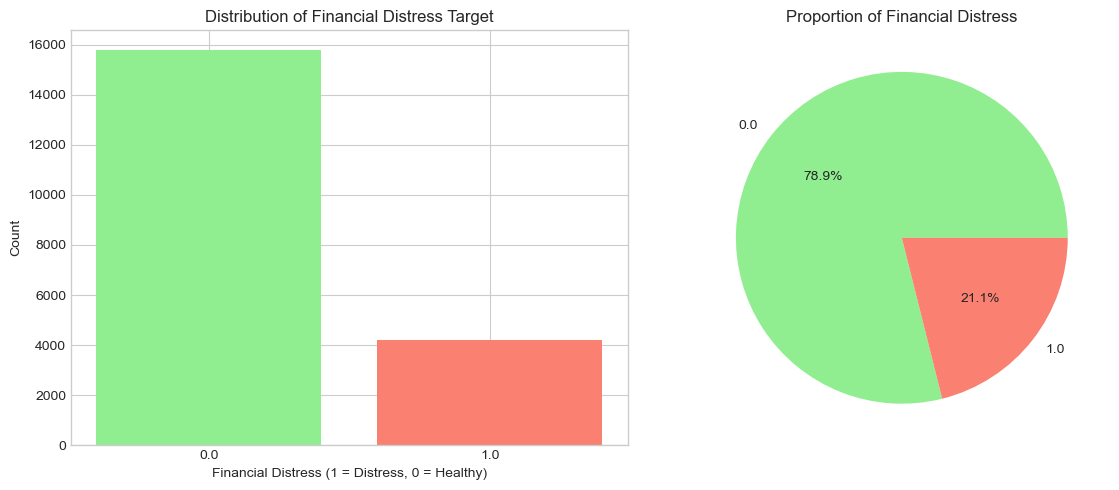

Class distribution: 15782 healthy vs 4218 distressed
Distress rate: 21.09%


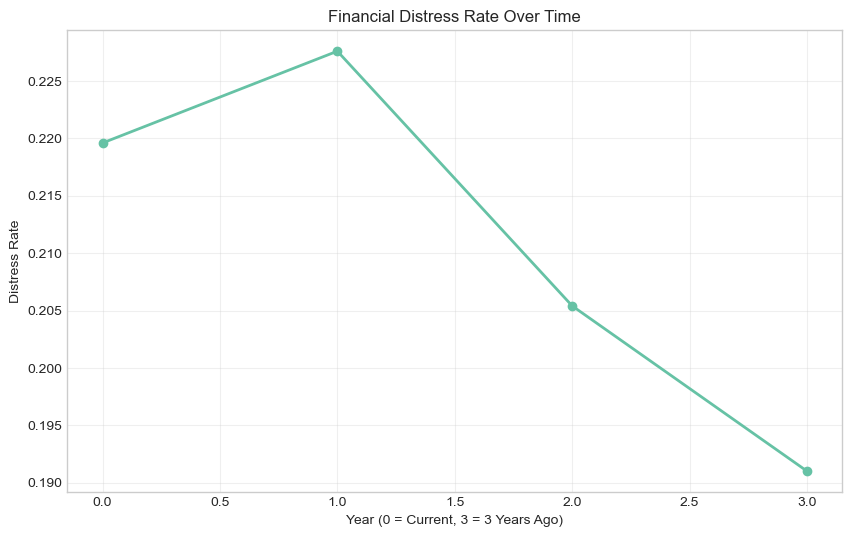

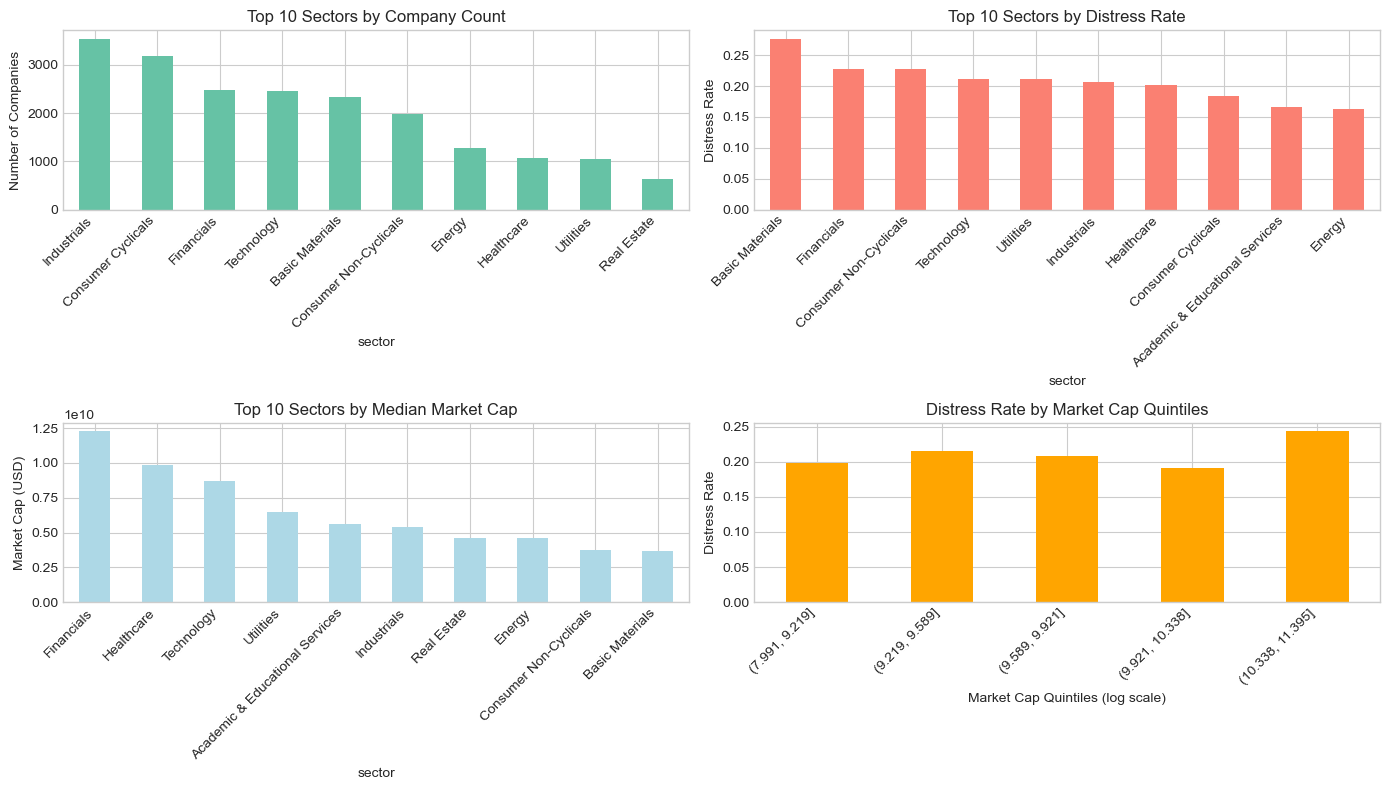

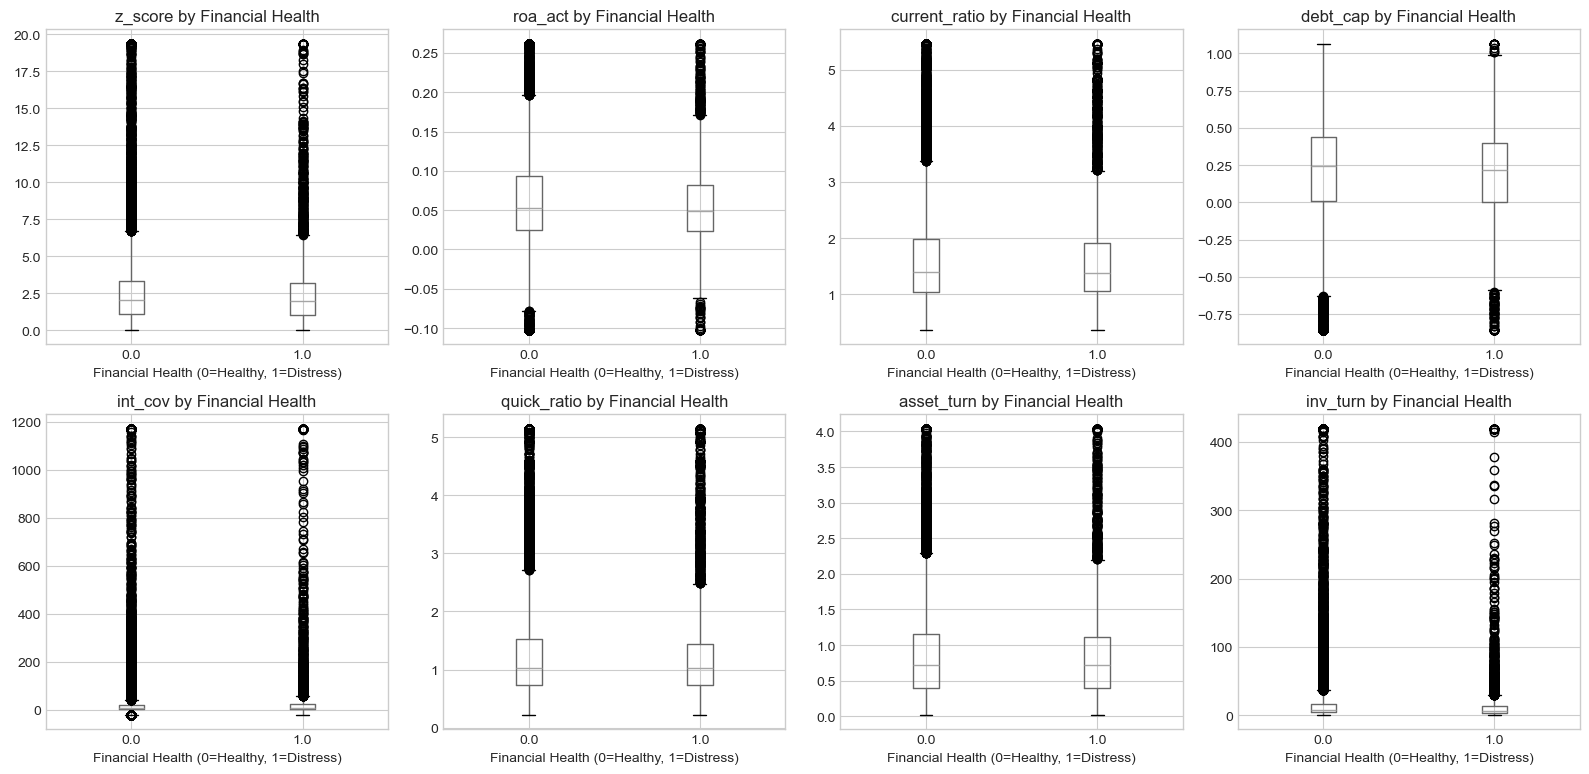

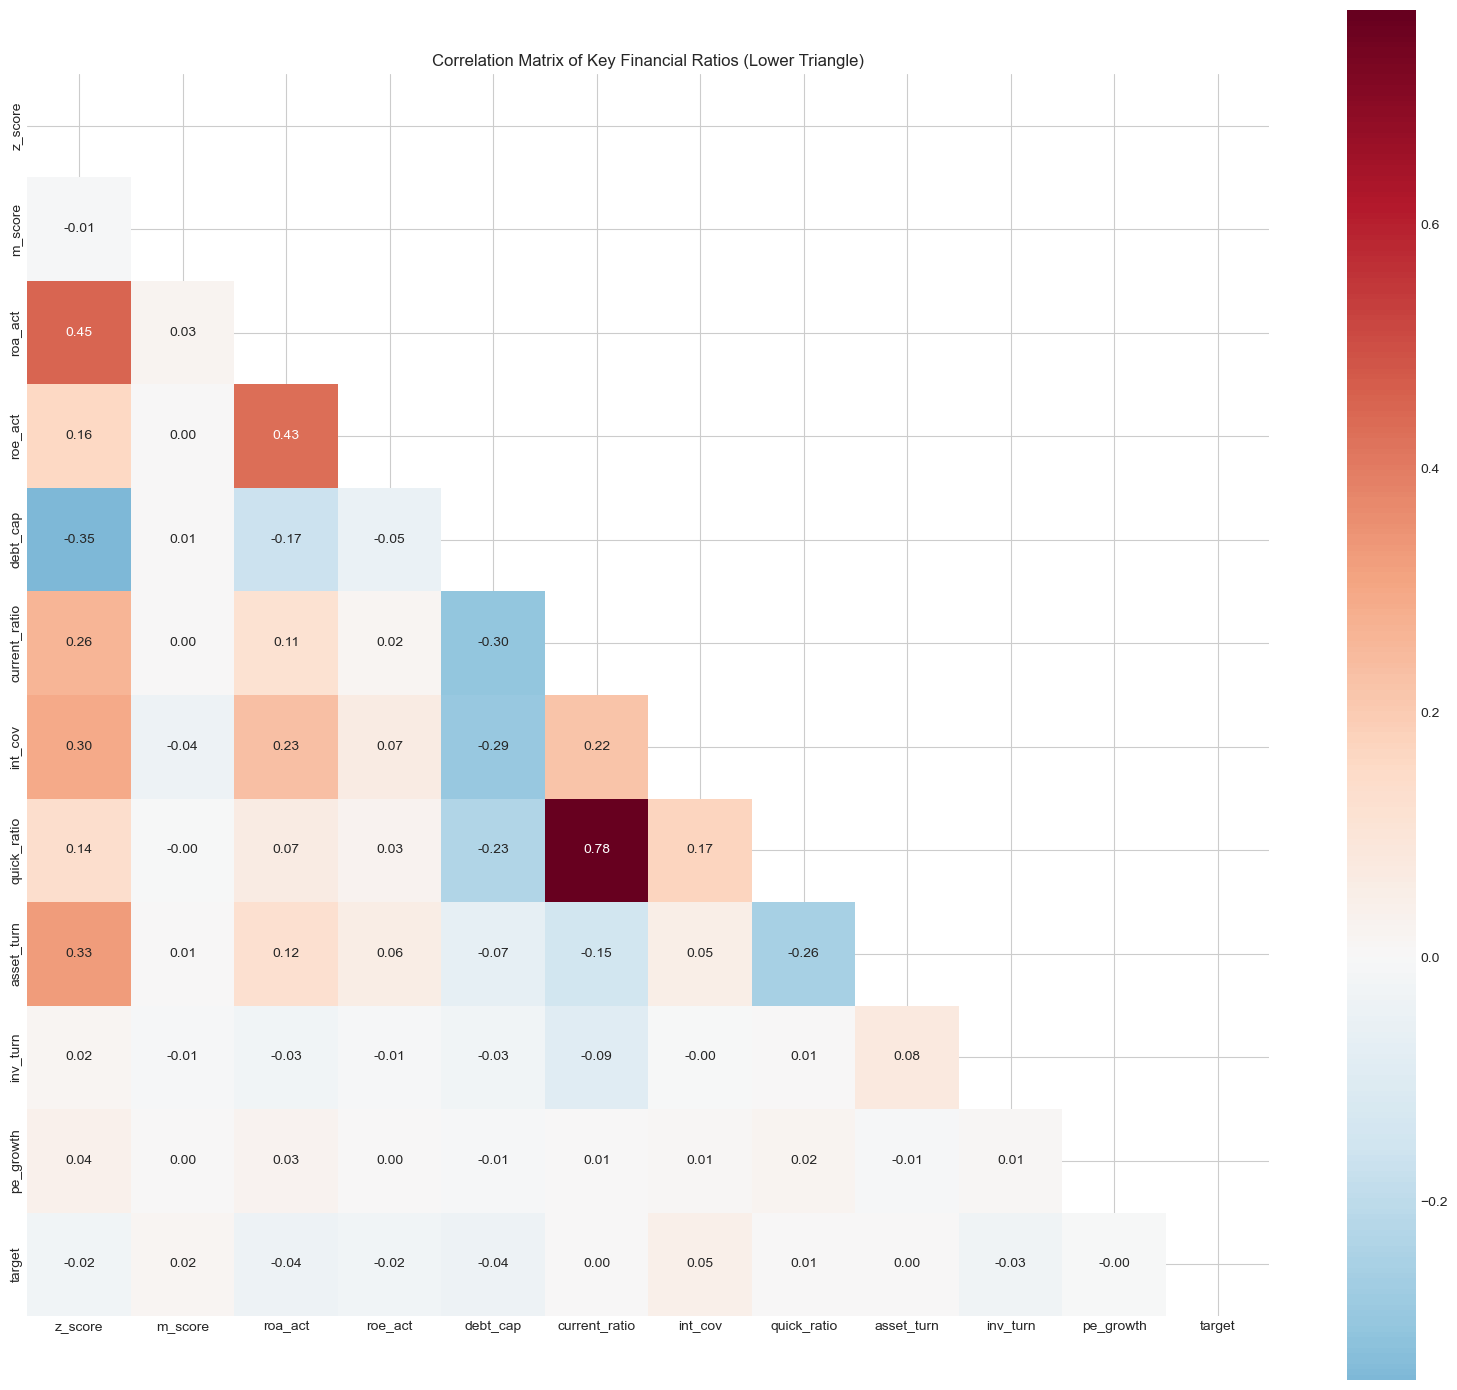

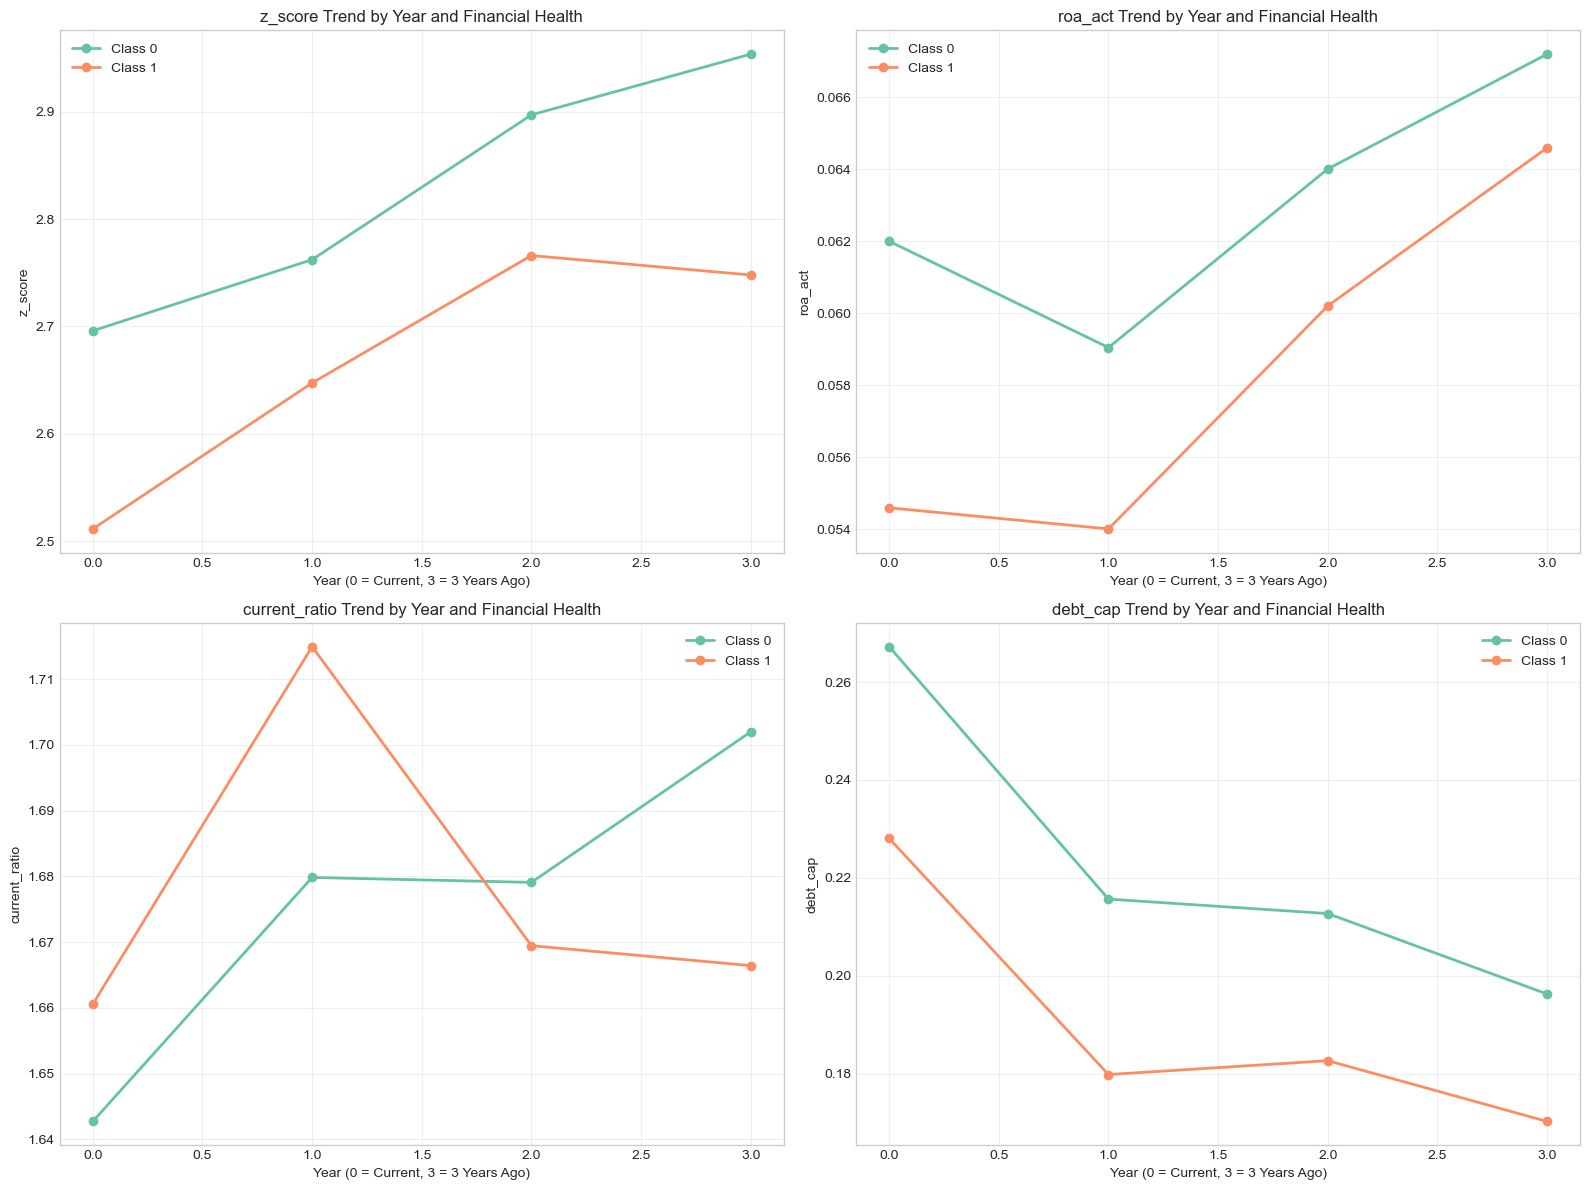

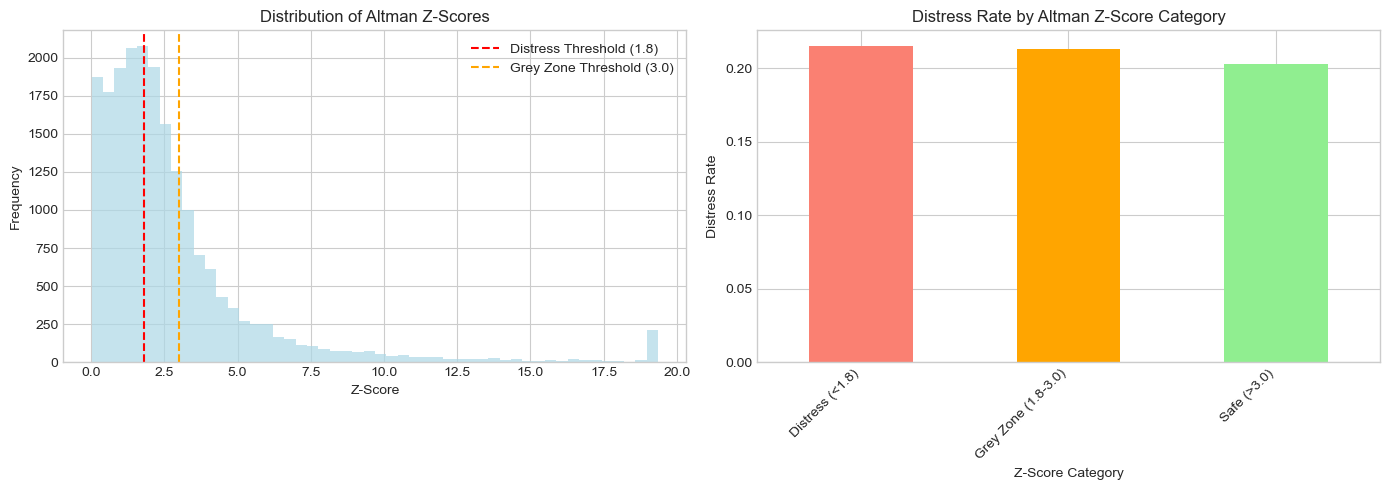

<Figure size 1200x1000 with 0 Axes>

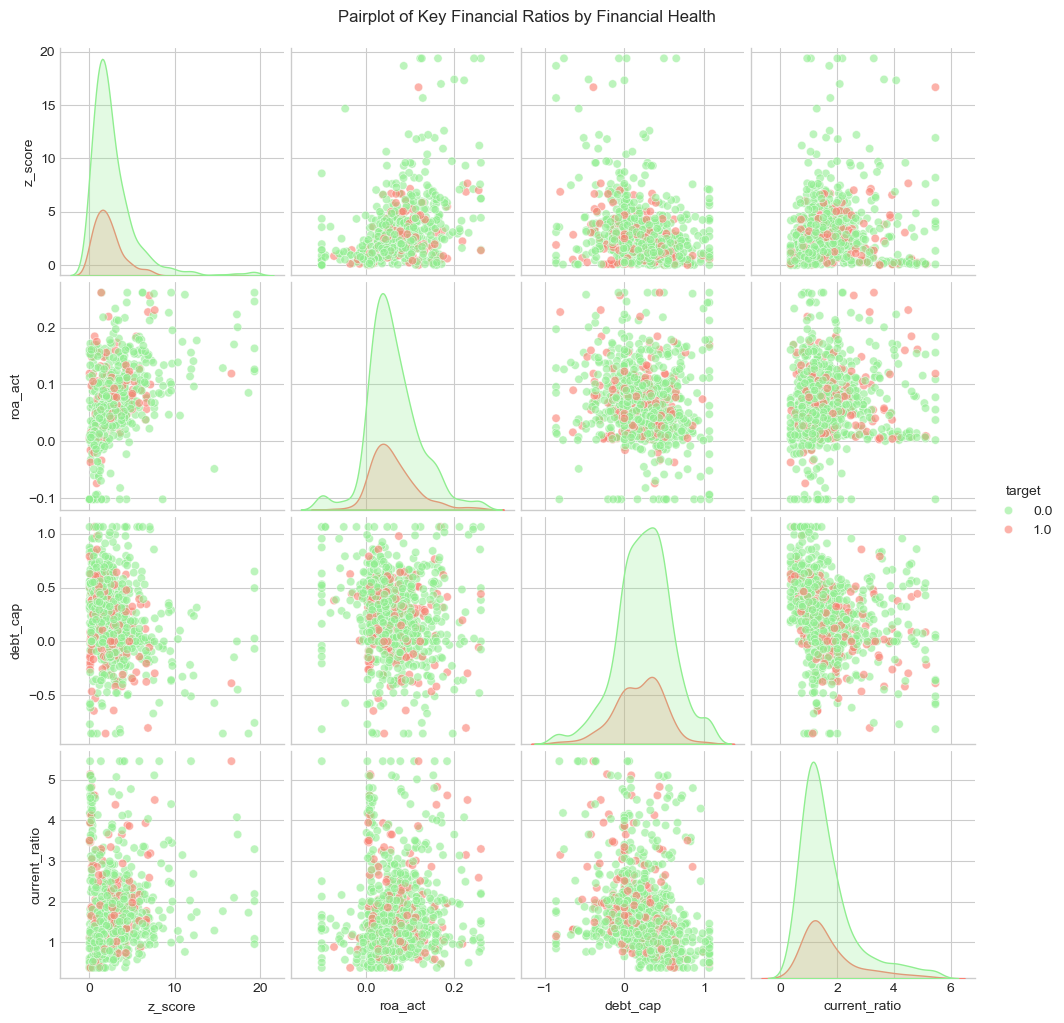

In [42]:
# COMPREHENSIVE EXPLORATORY DATA ANALYSIS 
def perform_eda(df):
    """
    Comprehensive exploratory analysis with enhanced visualizations:
    1. Target distribution analysis
    2. Temporal trends
    3. Sector analysis
    4. Financial ratio distributions
    5. Correlation analysis
    6. Time series trends
    7. Altman Z-Score analysis
    """
    print("=== EXPLORATORY DATA ANALYSIS ===\n")
    
    # 1. Target distribution analysis
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    target_counts = df['target'].value_counts()
    plt.bar(target_counts.index.astype(str), target_counts.values, 
            color=['lightgreen', 'salmon'])
    plt.title('Distribution of Financial Distress Target')
    plt.xlabel('Financial Distress (1 = Distress, 0 = Healthy)')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    plt.pie(target_counts.values, labels=target_counts.index.astype(str), 
            autopct='%1.1f%%', colors=['lightgreen', 'salmon'])
    plt.title('Proportion of Financial Distress')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Class distribution: {target_counts[0]} healthy vs {target_counts[1]} distressed")
    print(f"Distress rate: {target_counts[1] / len(df) * 100:.2f}%")
    
    # 2. Temporal analysis of distress rates
    plt.figure(figsize=(10, 6))
    yearly_distress = df.groupby('year')['target'].mean()
    plt.plot(yearly_distress.index, yearly_distress.values, marker='o', linewidth=2)
    plt.title('Financial Distress Rate Over Time')
    plt.xlabel('Year (0 = Current, 3 = 3 Years Ago)')
    plt.ylabel('Distress Rate')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 3. Sector analysis with enhanced visualizations
    if 'sector' in df.columns:
        plt.figure(figsize=(14, 8))
        
        # Sector distribution
        plt.subplot(2, 2, 1)
        sector_counts = df['sector'].value_counts().head(10)
        sector_counts.plot(kind='bar')
        plt.title('Top 10 Sectors by Company Count')
        plt.ylabel('Number of Companies')
        plt.xticks(rotation=45, ha='right')
        
        # Distress rate by sector
        plt.subplot(2, 2, 2)
        sector_distress = df.groupby('sector')['target'].mean().sort_values(ascending=False).head(10)
        sector_distress.plot(kind='bar', color='salmon')
        plt.title('Top 10 Sectors by Distress Rate')
        plt.ylabel('Distress Rate')
        plt.xticks(rotation=45, ha='right')
        
        # Market cap distribution by sector
        plt.subplot(2, 2, 3)
        if 'market_cap' in df.columns:
            sector_cap = df.groupby('sector')['market_cap'].median().sort_values(ascending=False).head(10)
            sector_cap.plot(kind='bar', color='lightblue')
            plt.title('Top 10 Sectors by Median Market Cap')
            plt.ylabel('Market Cap (USD)')
            plt.xticks(rotation=45, ha='right')
        
        # Distress rate vs market cap
        plt.subplot(2, 2, 4)
        if 'market_cap' in df.columns:
            df['log_market_cap'] = np.log10(df['market_cap'] + 1)
            cap_bins = pd.qcut(df['log_market_cap'], 5, duplicates='drop')
            cap_distress = df.groupby(cap_bins)['target'].mean()
            cap_distress.plot(kind='bar', color='orange')
            plt.title('Distress Rate by Market Cap Quintiles')
            plt.ylabel('Distress Rate')
            plt.xlabel('Market Cap Quintiles (log scale)')
            plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    # 4. Distribution of key financial ratios by target class
    key_ratios = ['z_score', 'roa_act', 'current_ratio', 'debt_cap', 
                 'int_cov', 'quick_ratio', 'asset_turn', 'inv_turn']
    
    existing_ratios = [ratio for ratio in key_ratios if ratio in df.columns]
    
    # Create comparative boxplots
    n_cols = 4
    n_rows = int(np.ceil(len(existing_ratios) / n_cols))
    
    plt.figure(figsize=(16, 4 * n_rows))
    for i, ratio in enumerate(existing_ratios, 1):
        plt.subplot(n_rows, n_cols, i)
        df.boxplot(column=ratio, by='target', ax=plt.gca())
        plt.title(f'{ratio} by Financial Health')
        plt.suptitle('')  # Suppress automatic title
        plt.xlabel('Financial Health (0=Healthy, 1=Distress)')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Enhanced correlation analysis
    plt.figure(figsize=(16, 14))
    
    corr_features = [
        'z_score', 'm_score', 'manip_risk', 'roa_act', 'roe_act',
        'debt_cap', 'current_ratio', 'int_cov', 'quick_ratio', 
        'asset_turn', 'inv_turn', 'pe_growth', 'target'
    ]
    
    corr_features = [f for f in corr_features if f in df.columns]
    
    correlation_matrix = df[corr_features].corr()
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
                fmt='.2f', mask=mask, square=True)
    plt.title('Correlation Matrix of Key Financial Ratios (Lower Triangle)')
    plt.tight_layout()
    plt.show()
    
    # 6. Time series trends for key ratios by target class
    plt.figure(figsize=(16, 12))
    
    trend_ratios = ['z_score', 'roa_act', 'current_ratio', 'debt_cap']
    
    for i, ratio in enumerate(trend_ratios, 1):
        if ratio in df.columns:
            plt.subplot(2, 2, i)
            
            # Calculate mean by year and target class
            trend_data = df.groupby(['year', 'target'])[ratio].mean().unstack()
            
            for target_class in [0, 1]:
                if target_class in trend_data.columns:
                    plt.plot(trend_data.index, trend_data[target_class], 
                            label=f'Class {target_class}', marker='o', linewidth=2)
            
            plt.title(f'{ratio} Trend by Year and Financial Health')
            plt.xlabel('Year (0 = Current, 3 = 3 Years Ago)')
            plt.ylabel(ratio)
            plt.legend()
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 7. Altman Z-Score threshold analysis
    if 'z_score' in df.columns:
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(df['z_score'].dropna(), bins=50, alpha=0.7, color='lightblue')
        plt.axvline(x=1.8, color='red', linestyle='--', label='Distress Threshold (1.8)')
        plt.axvline(x=3.0, color='orange', linestyle='--', label='Grey Zone Threshold (3.0)')
        plt.title('Distribution of Altman Z-Scores')
        plt.xlabel('Z-Score')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        z_categories = pd.cut(df['z_score'], 
                             bins=[-np.inf, 1.8, 3.0, np.inf],
                             labels=['Distress (<1.8)', 'Grey Zone (1.8-3.0)', 'Safe (>3.0)'])
        z_distress = df.groupby(z_categories)['target'].mean()
        z_distress.plot(kind='bar', color=['salmon', 'orange', 'lightgreen'])
        plt.title('Distress Rate by Altman Z-Score Category')
        plt.xlabel('Z-Score Category')
        plt.ylabel('Distress Rate')
        plt.xticks(rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    # 8. Pairplot of key variables (sampled for performance)
    if len(df) > 1000:
        sample_df = df.sample(1000, random_state=42)
    else:
        sample_df = df
        
    pairplot_vars = ['z_score', 'roa_act', 'debt_cap', 'current_ratio', 'target']
    pairplot_vars = [v for v in pairplot_vars if v in sample_df.columns]
    
    if len(pairplot_vars) > 1:
        plt.figure(figsize=(12, 10))
        sns.pairplot(sample_df[pairplot_vars], hue='target', 
                    palette={0: 'lightgreen', 1: 'salmon'}, 
                    plot_kws={'alpha': 0.6})
        plt.suptitle('Pairplot of Key Financial Ratios by Financial Health', y=1.02)
        plt.show()

# Perform comprehensive EDA
perform_eda(panel_df)

In [43]:
# STATISTICAL SIGNIFICANCE TESTING
def perform_statistical_tests(df):
    """
    Identify statistically significant predictors using:
    - Independent t-tests
    - Mann-Whitney U tests
    - Effect size calculation (Cohen's d)
    - Multiple testing correction
    """
    from scipy.stats import ttest_ind, mannwhitneyu
    from statsmodels.stats.multitest import multipletests
    
    print("=== STATISTICAL TESTING ===\n")
    
    # Select numeric features for testing
    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_features = [f for f in numeric_features if f != 'target' and f != 'year']
    
    results = []
    
    for feature in numeric_features:
        # Separate by target class
        group_0 = df[df['target'] == 0][feature].dropna()
        group_1 = df[df['target'] == 1][feature].dropna()
        
        if len(group_0) > 10 and len(group_1) > 10:  # Ensure sufficient sample size
            # T-test
            t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)
            
            # Mann-Whitney U test (non-parametric)
            u_stat, u_pvalue = mannwhitneyu(group_0, group_1)
            
            # Effect size (Cohen's d)
            mean_diff = group_0.mean() - group_1.mean()
            pooled_std = np.sqrt((group_0.std()**2 + group_1.std()**2) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else 0
            
            results.append({
                'feature': feature,
                't_statistic': t_stat,
                'p_value': p_value,
                'u_pvalue': u_pvalue,
                'cohens_d': cohens_d,
                'mean_0': group_0.mean(),
                'mean_1': group_1.mean()
            })
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Apply multiple testing correction
    rejected, corrected_pvals, _, _ = multipletests(
        results_df['p_value'], method='fdr_bh'
    )
    results_df['p_value_corrected'] = corrected_pvals
    results_df['significant'] = rejected
    
    # Sort by effect size
    results_df = results_df.sort_values('cohens_d', key=abs, ascending=False)
    
    # Display top predictors
    print("Top 20 predictors by effect size:")
    display(results_df.head(20)[['feature', 'cohens_d', 'p_value_corrected', 'significant', 
                               'mean_0', 'mean_1']])
    
    return results_df

# Perform statistical testing
stats_results = perform_statistical_tests(panel_df)

=== STATISTICAL TESTING ===

Top 20 predictors by effect size:


,feature,cohens_d,p_value_corrected,significant,mean_0,mean_1
50,debt_lag1,-0.188210,2.909845e-21,True,7.478120e+09,1.174357e+10
17,debt,-0.186847,3.029922e-21,True,7.368124e+09,1.158895e+10
48,cfo_lag1,-0.170023,8.521728e-18,True,1.396388e+09,2.068615e+09
16,cfo,-0.164196,8.181026e-17,True,1.424676e+09,2.104675e+09
55,current_ratio_volatility,0.152625,3.429715e-19,True,1.849473e-01,1.528513e-01
0,market_cap,-0.144407,1.635812e-13,True,1.735671e+10,2.334805e+10
26,ebit_ta_lag1,0.129619,1.435454e-13,True,7.215485e-02,6.385571e-02
52,roa_act_volatility,0.120081,4.066836e-12,True,2.115896e-02,1.805522e-02
4,re_ta,-0.115104,8.222753e-12,True,2.004434e-01,2.291752e-01
34,debt_cap_lag1,0.114711,5.279432e-11,True,2.411335e-01,2.071845e-01


In [44]:
# FEATURE SELECTION
def select_features(X, y, method='kbest', k=30):
    
    if method == 'kbest':
        selector = SelectKBest(score_func=f_classif, k=k)
    elif method == 'rfe':
        estimator = LogisticRegression(class_weight='balanced', max_iter=1000)
        selector = RFE(estimator, n_features_to_select=k)
    else:
        raise ValueError("Method must be 'kbest' or 'rfe'")
    
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    
    print(f"Selected {len(selected_features)} features using {method}:")
    print(selected_features)
    
    return X_selected, selected_features, selector


In [45]:
# TEMPORAL MODELING DATA PREPARATION
def prepare_modeling_data(df, prediction_horizon=1):
    
    # Sort by company and year
    df = df.sort_values(['ric', 'year'])
    
    # Create future target (predict distress in next year)
    df['future_target'] = df.groupby('ric')['target'].shift(-prediction_horizon)
    
    # Remove rows with unknown future target
    df = df.dropna(subset=['future_target'])
    
    # Filter to features available at prediction time
    exclude_cols = ['ric', 'company_name', 'sector', 'year', 'future_target', 'target']
    feature_columns = [col for col in df.columns if col not in exclude_cols]
    
    X = df[feature_columns]
    y = df['future_target']
    
    # Get identifiers for time-based splitting
    companies = df['ric']
    years = df['year']
    
    return X, y, companies, years, df

# Prepare modeling data
X, y, companies, years, panel_df = prepare_modeling_data(panel_df, prediction_horizon=1)

print(f"Final dataset shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Identify numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Apply robust scaling for outlier resistance
scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Apply feature selection
X_selected, selected_features, selector = select_features(X_scaled, y, method='kbest', k=30)
X_scaled = X_scaled[selected_features]


Final dataset shape: (15000, 62)
Target distribution:
future_target
0.0    11880
1.0     3120
Name: count, dtype: int64
Selected 30 features using kbest:
['market_cap', 'z_score', 'wc_ta', 're_ta', 'ebit_ta', 'roa_act', 'roe_act', 'debt_cap', 'int_cov', 'inv_turn', 'cfo', 'debt', 'z_score_lag1', 'wc_ta_lag1', 're_ta_lag1', 'ebit_ta_lag1', 'roa_act_lag1', 'debt_cap_lag1', 'int_cov_lag1', 'inv_turn_lag1', 'cfo_lag1', 'debt_lag1', 'debt_growth', 'roa_act_volatility', 'roe_act_volatility', 'debt_cap_volatility', 'current_ratio_volatility', 'roa_act_trend', 'ebit_debt_ratio', 'log_market_cap']


Train set: (10000, 30), years: 1.0 to 2.0
Test set: (5000, 30), years: 0.0 to 0.0

Training set target distribution:
future_target
0.0    8018
1.0    1982
Name: count, dtype: int64
Test set target distribution:
future_target
0.0    3862
1.0    1138
Name: count, dtype: int64


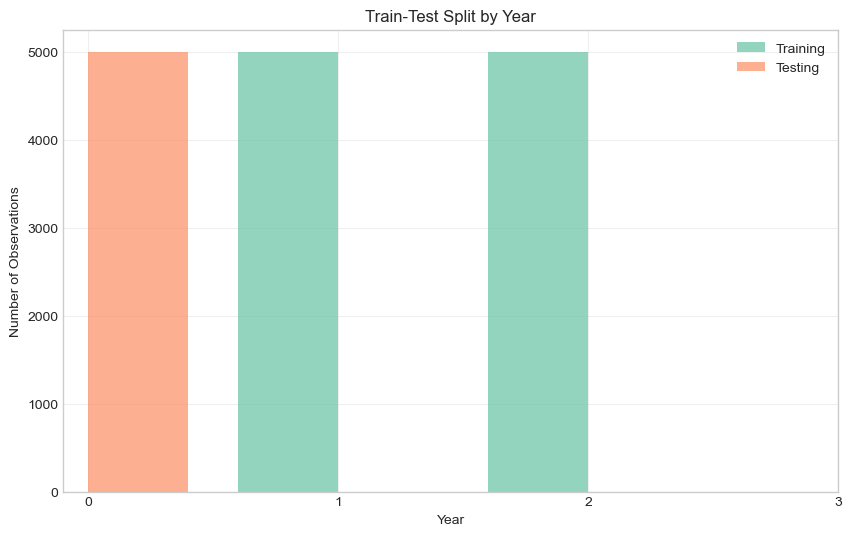

In [46]:
# TIME-AWARE DATA SPLITTING 
def time_aware_split(X, y, companies, years, test_year=0):
    
    # Create dataframe with temporal information
    data_info = pd.DataFrame({
        'company': companies.values,
        'year': years.values
    }, index=X.index)
    
    # Create masks for temporal splitting
    test_mask = data_info['year'] == test_year
    train_mask = data_info['year'] > test_year
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]
    
    print(f"Train set: {X_train.shape}, years: {data_info[train_mask]['year'].min()} to {data_info[train_mask]['year'].max()}")
    print(f"Test set: {X_test.shape}, years: {data_info[test_mask]['year'].min()} to {data_info[test_mask]['year'].max()}")
    
    # Validate split adequacy
    if len(X_train) == 0 or len(X_test) == 0:
        raise ValueError("Insufficient data for training or testing. Check your year values.")
    
    return X_train, X_test, y_train, y_test

# Apply time-aware split
X_train, X_test, y_train, y_test = time_aware_split(X_scaled, y, companies, years, test_year=0)

# Verify split characteristics
print(f"\nTraining set target distribution:\n{y_train.value_counts()}")
print(f"Test set target distribution:\n{y_test.value_counts()}")

# Visualize the temporal split
plt.figure(figsize=(10, 6))
year_counts_train = pd.Series(years[X_train.index]).value_counts().sort_index()
year_counts_test = pd.Series(years[X_test.index]).value_counts().sort_index()

plt.bar(year_counts_train.index - 0.2, year_counts_train.values, width=0.4, label='Training', alpha=0.7)
plt.bar(year_counts_test.index + 0.2, year_counts_test.values, width=0.4, label='Testing', alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.title('Train-Test Split by Year')
plt.legend()
plt.xticks([0, 1, 2, 3])
plt.grid(True, alpha=0.3)
plt.show()

In [47]:
# CLASS IMBALANCE HANDLING
# Calculate balanced class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(f"Class weights: {class_weight_dict}")


Class weights: {np.float64(0.0): np.float64(0.6235969069593414), np.float64(1.0): np.float64(2.522704339051463)}


In [48]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score
)
from sklearn.model_selection import StratifiedKFold


# --- HELPER FUNCTIONS ---
def evaluate_model(y_true, y_proba, threshold=0.5):
    """
    Compute metrics for given probabilities and threshold.
    """
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "roc_auc": roc_auc_score(y_true, y_proba),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "threshold": threshold,
    }


def find_best_threshold(y_true, y_proba, metric="f1"):
    """
    Find the threshold that maximizes a given metric.
    Supported metrics: 'f1', 'precision', 'recall', 'balanced_accuracy'
    """
    thresholds = np.linspace(0.0, 1.0, 201)  # test thresholds from 0.0 to 1.0
    best_thresh, best_score = 0.5, -1

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        if metric == "f1":
            score = f1_score(y_true, y_pred, zero_division=0)
        elif metric == "precision":
            score = precision_score(y_true, y_pred, zero_division=0)
        elif metric == "recall":
            score = recall_score(y_true, y_pred, zero_division=0)
        elif metric == "balanced_accuracy":
            score = balanced_accuracy_score(y_true, y_pred)
        else:
            raise ValueError("Unsupported metric. Choose 'f1', 'precision', 'recall', or 'balanced_accuracy'.")

        if score > best_score:
            best_score, best_thresh = score, t

    return best_thresh


# --- MAIN TRAINING FUNCTION ---
def train_models(X_train, y_train, X_test, y_test, tune_threshold=True, threshold_metric="f1", cv_splits=0):
    """
    Train and evaluate multiple models with optional cross-validation and threshold tuning.

    Args:
        X_train, y_train: Training data
        X_test, y_test: Test data
        tune_threshold (bool): Whether to optimize probability threshold
        threshold_metric (str): Metric to optimize threshold on
        cv_splits (int): If >1, performs StratifiedKFold CV

    Returns:
        trained_models (dict): Fitted models
        results_df (pd.DataFrame): Metrics for each model
    """
    results = {}
    trained_models = {}

    # Ensure numpy arrays
    X_train_np = np.asarray(X_train)
    y_train_np = np.asarray(y_train)
    X_test_np = np.asarray(X_test)
    y_test_np = np.asarray(y_test)

    # Define models
    model_configs = {
        "logistic": LogisticRegression(
            class_weight="balanced", random_state=42, max_iter=1000
        ),
        "random_forest": RandomForestClassifier(
            class_weight="balanced", random_state=42, n_estimators=200
        ),
        "xgboost": xgb.XGBClassifier(
            scale_pos_weight=len(y_train_np[y_train_np == 0]) / len(y_train_np[y_train_np == 1]),
            random_state=42, eval_metric="logloss", use_label_encoder=False
        ),
        "lightgbm": lgb.LGBMClassifier(
            class_weight="balanced", random_state=42, n_estimators=200
        ),
    }

    # Train each model
    for name, model in model_configs.items():
        print(f"\nTraining {name}...")
        model.fit(X_train_np, y_train_np)

        # Predictions
        y_proba = model.predict_proba(X_test_np)[:, 1]

        # Tune threshold (optional)
        threshold = 0.5
        if tune_threshold:
            threshold = find_best_threshold(y_test_np, y_proba, metric=threshold_metric)

        # Evaluate
        metrics = evaluate_model(y_test_np, y_proba, threshold)
        results[name] = metrics
        trained_models[name] = model

        print(
            f"{name} - AUC: {metrics['roc_auc']:.3f}, "
            f"Precision: {metrics['precision']:.3f}, "
            f"Recall: {metrics['recall']:.3f}, "
            f"F1: {metrics['f1']:.3f}, "
            f"Thr: {metrics['threshold']:.2f}"
        )

        # Optional cross-validation evaluation
        if cv_splits > 1:
            cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
            cv_scores = []
            for train_idx, val_idx in cv.split(X_train_np, y_train_np):
                X_tr, X_val = X_train_np[train_idx], X_train_np[val_idx]
                y_tr, y_val = y_train_np[train_idx], y_train_np[val_idx]
                model.fit(X_tr, y_tr)
                y_val_proba = model.predict_proba(X_val)[:, 1]
                val_thr = find_best_threshold(y_val, y_val_proba, metric=threshold_metric) if tune_threshold else 0.5
                val_metrics = evaluate_model(y_val, y_val_proba, val_thr)
                cv_scores.append(val_metrics["f1"])
            print(f"  CV mean F1: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

    # Convert to DataFrame for easy comparison
    results_df = pd.DataFrame(results).T.sort_values(by="f1", ascending=False)
    return trained_models, results_df


# --- USAGE EXAMPLE ---
trained_models, results = train_models(X_train, y_train, X_test, y_test,
                                        tune_threshold=True,
                                        threshold_metric="f1",
                                        cv_splits=5)
print(results)



Training logistic...
logistic - AUC: 0.608, Precision: 0.279, Recall: 0.779, F1: 0.411, Thr: 0.48
  CV mean F1: 0.365 ± 0.007

Training random_forest...
random_forest - AUC: 0.831, Precision: 0.687, Recall: 0.648, F1: 0.667, Thr: 0.28
  CV mean F1: 0.474 ± 0.016

Training xgboost...
xgboost - AUC: 0.800, Precision: 0.557, Recall: 0.641, F1: 0.596, Thr: 0.39
  CV mean F1: 0.417 ± 0.007

Training lightgbm...
[LightGBM] [Info] Number of positive: 1982, number of negative: 8018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
lightgbm - AUC: 0.808, Precision: 0.526, Recall: 0.663, F1: 0.587, Thr: 0.44
[LightGBM] [Info] Numb


Training logistic...
logistic - AUC: 0.608, Precision: 0.279, Recall: 0.779, F1: 0.411, Thr: 0.48
  CV mean F1: 0.365 ± 0.007

Training random_forest...
random_forest - AUC: 0.831, Precision: 0.687, Recall: 0.648, F1: 0.667, Thr: 0.28
  CV mean F1: 0.474 ± 0.016

Training xgboost...
xgboost - AUC: 0.800, Precision: 0.557, Recall: 0.641, F1: 0.596, Thr: 0.39
  CV mean F1: 0.417 ± 0.007

Training lightgbm...
[LightGBM] [Info] Number of positive: 1982, number of negative: 8018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
lightgbm - AUC: 0.808, Precision: 0.526, Recall: 0.663, F1: 0.587, Thr: 0.44
[LightGBM] [Info] Numb

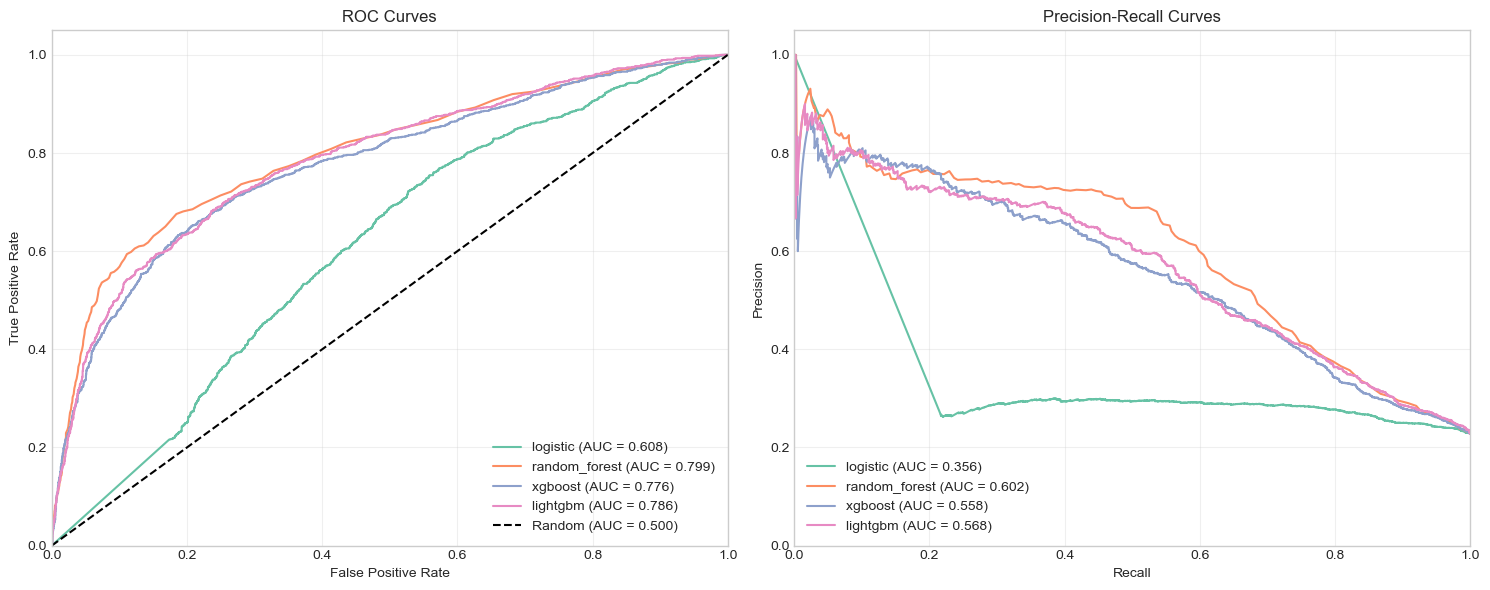

=== TEMPORAL GENERALIZATION ANALYSIS ===

Input lengths: {'X': 5000, 'y': 5000, 'companies': 15000, 'years': 15000}
Year 0.0: ROC AUC = 0.789, Samples = 1667
Year 1.0: ROC AUC = 0.801, Samples = 1667
Year 2.0: ROC AUC = 0.806, Samples = 1666


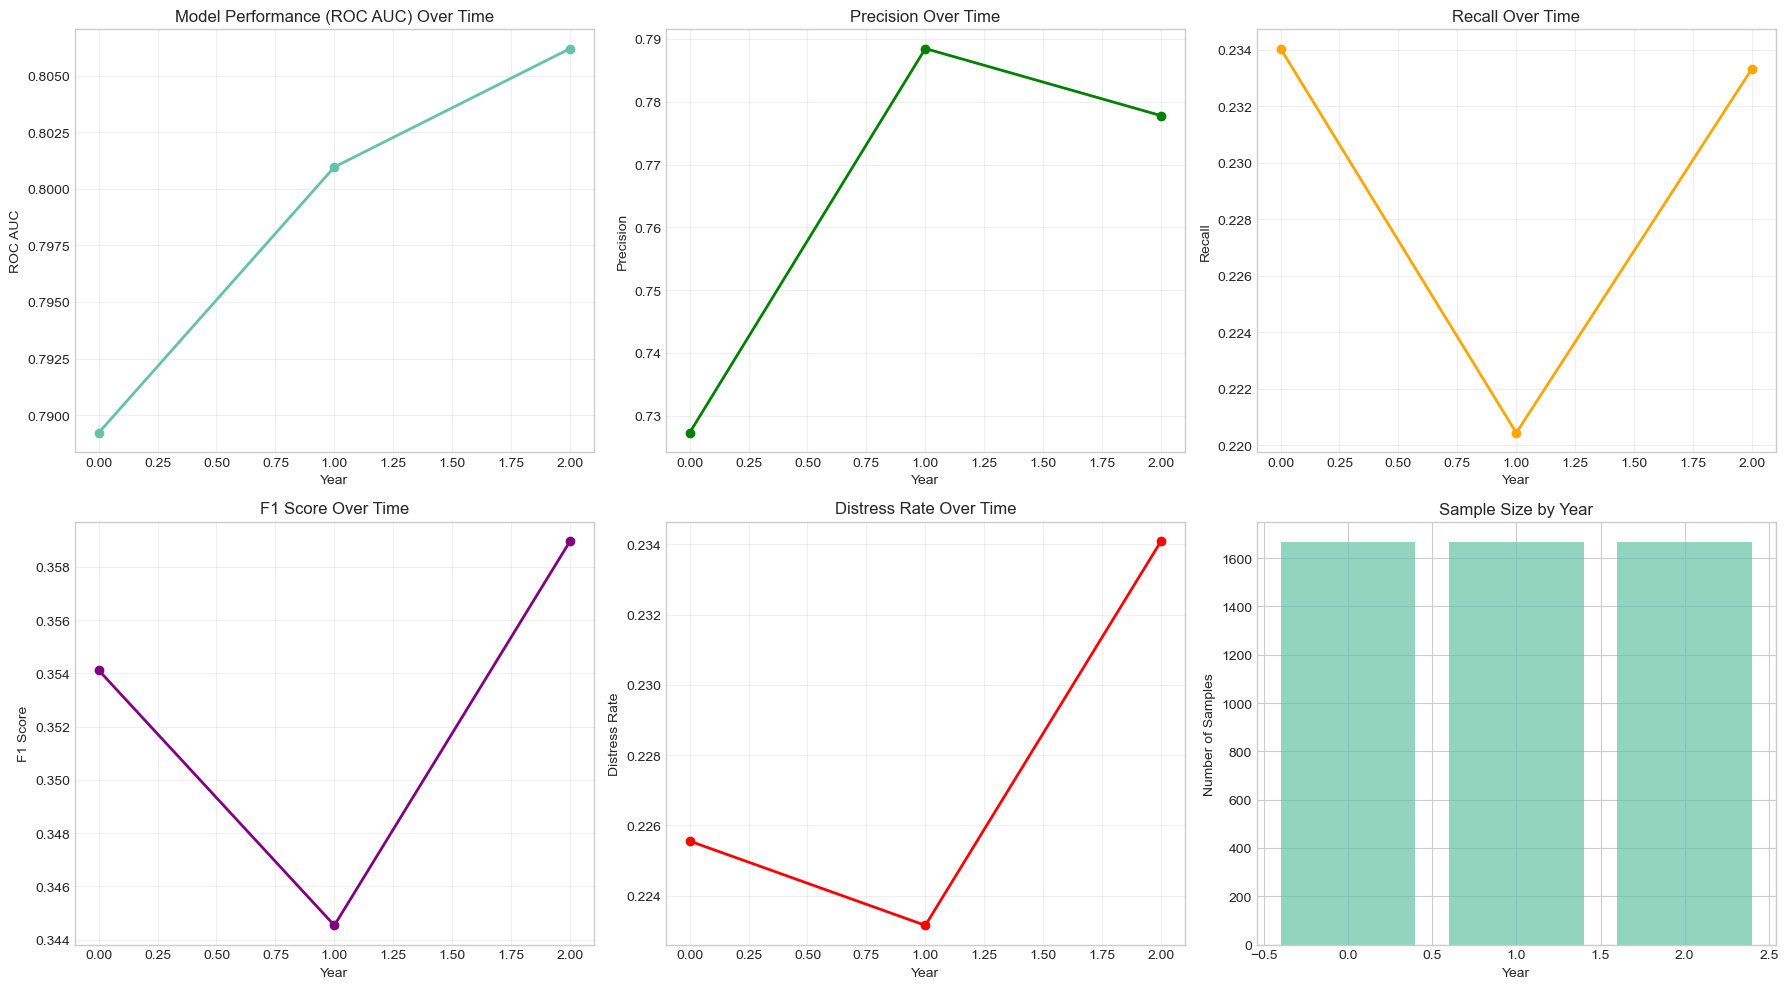

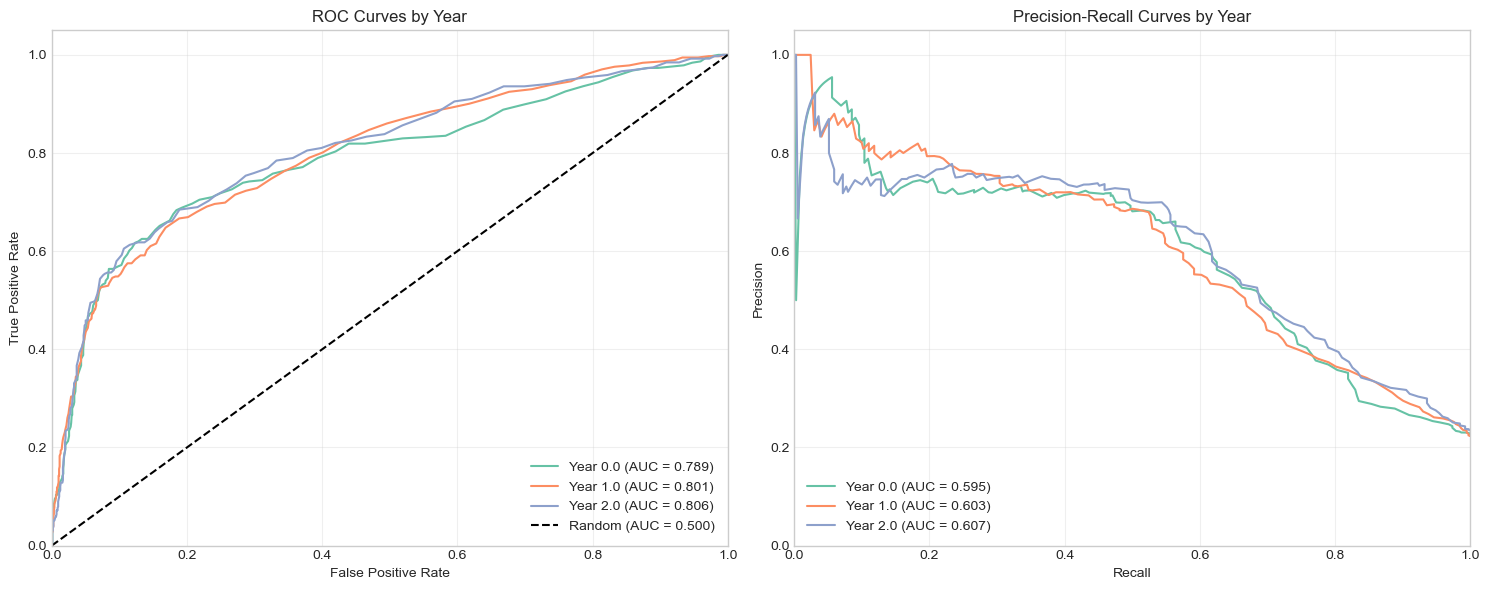


Temporal Performance Results:


,year,roc_auc,precision,recall,f1,samples,distress_rate
0,0.0,0.789214,0.727273,0.234043,0.354125,1667,0.225555
1,1.0,0.800964,0.788462,0.220430,0.344538,1667,0.223155
2,2.0,0.806200,0.777778,0.233333,0.358974,1666,0.234094


ROC AUC decline from first to last year: -0.017
✅ Model performance is relatively stable over time.


In [49]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, precision_score, recall_score, f1_score

# --- HELPER FUNCTION FOR PLOTTING CURVES ---
def plot_model_curves(models, X_test, y_test):
    """
    Plot ROC and Precision-Recall curves for all trained models.
    """
    X_test_np = np.asarray(X_test)
    y_test_np = np.asarray(y_test)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot ROC curves
    for name, model in models.items():
        y_proba = model.predict_proba(X_test_np)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_np, y_proba)
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    ax1.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)

    # Plot Precision-Recall curves
    for name, model in models.items():
        y_proba = model.predict_proba(X_test_np)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test_np, y_proba)
        pr_auc = auc(recall, precision)
        ax2.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')
    
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves')
    ax2.legend(loc='lower left')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- TEMPORAL GENERALIZATION ANALYSIS ---
def analyze_temporal_generalization(X, y, companies, years, model):
    """
    Analyze how model performance changes over time with proper data alignment.
    
    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        Target labels
    companies : array-like or pd.Series
        Company identifiers
    years : array-like or pd.Series
        Year labels
    model : sklearn-like estimator
        Must support predict and predict_proba
    """
    print("=== TEMPORAL GENERALIZATION ANALYSIS ===\n")
    
    # --- Step 1: Enforce consistent lengths ---
    lengths = {
        "X": len(X),
        "y": len(y),
        "companies": len(companies),
        "years": len(years)
    }
    print("Input lengths:", lengths)
    
    min_len = min(lengths.values())
    if len(set(lengths.values())) > 1:
        print(f"Warning: Length mismatch detected. Trimming all inputs to {min_len} rows.")
    
    # Trim & reset indices
    X = X.reset_index(drop=True).iloc[:min_len]
    y = pd.Series(np.array(y)[:min_len], name=getattr(y, "name", "target"))
    companies = pd.Series(np.array(companies)[:min_len], name="company")
    years = pd.Series(np.array(years)[:min_len], name="year")
    
    # --- Step 2: Build data info ---
    data_info = pd.DataFrame({
        'year': years.values,
        'company': companies.values
    }, index=X.index)
    
    # --- Step 3: Evaluate performance by year ---
    yearly_performance = []
    unique_years = sorted(data_info['year'].unique())
    
    # For ROC and PR curves by year
    roc_curves = {}
    pr_curves = {}
    
    for year in unique_years:
        year_mask = data_info['year'] == year
        X_year = X[year_mask]
        y_year = y[year_mask]
        
        if len(y_year) > 10 and len(np.unique(y_year)) > 1:  # Ensure sufficient data
            try:
                y_pred_proba = model.predict_proba(X_year)[:, 1]
                roc_auc = roc_auc_score(y_year, y_pred_proba)
                
                # Additional metrics
                y_pred = model.predict(X_year)
                precision = precision_score(y_year, y_pred, zero_division=0)
                recall = recall_score(y_year, y_pred, zero_division=0)
                f1 = f1_score(y_year, y_pred, zero_division=0)
                
                yearly_performance.append({
                    'year': year,
                    'roc_auc': roc_auc,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'samples': len(y_year),
                    'distress_rate': y_year.mean()
                })
                
                # Store curve data for later plotting
                fpr, tpr, _ = roc_curve(y_year, y_pred_proba)
                prec, rec, _ = precision_recall_curve(y_year, y_pred_proba)
                roc_curves[year] = (fpr, tpr, roc_auc)
                pr_curves[year] = (rec, prec, auc(rec, prec))
                
                print(f"Year {year}: ROC AUC = {roc_auc:.3f}, Samples = {len(y_year)}")
                
            except Exception as e:
                print(f"Error evaluating year {year}: {e}")
                continue
    
    # --- Step 4: Collect results ---
    if not yearly_performance:
        print("No valid yearly performance data available.")
        return pd.DataFrame()
    
    performance_df = pd.DataFrame(yearly_performance)
    
    # --- Step 5: Plot results ---
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    axes[0, 0].plot(performance_df['year'], performance_df['roc_auc'], marker='o', linewidth=2)
    axes[0, 0].set_title('Model Performance (ROC AUC) Over Time')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('ROC AUC')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(performance_df['year'], performance_df['precision'], marker='o', linewidth=2, color='green')
    axes[0, 1].set_title('Precision Over Time')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[0, 2].plot(performance_df['year'], performance_df['recall'], marker='o', linewidth=2, color='orange')
    axes[0, 2].set_title('Recall Over Time')
    axes[0, 2].set_xlabel('Year')
    axes[0, 2].set_ylabel('Recall')
    axes[0, 2].grid(True, alpha=0.3)
    
    axes[1, 0].plot(performance_df['year'], performance_df['f1'], marker='o', linewidth=2, color='purple')
    axes[1, 0].set_title('F1 Score Over Time')
    axes[1, 0].set_xlabel('Year')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].plot(performance_df['year'], performance_df['distress_rate'], marker='o', linewidth=2, color='red')
    axes[1, 1].set_title('Distress Rate Over Time')
    axes[1, 1].set_xlabel('Year')
    axes[1, 1].set_ylabel('Distress Rate')
    axes[1, 1].grid(True, alpha=0.3)
    
    axes[1, 2].bar(performance_df['year'], performance_df['samples'], alpha=0.7)
    axes[1, 2].set_title('Sample Size by Year')
    axes[1, 2].set_xlabel('Year')
    axes[1, 2].set_ylabel('Number of Samples')
    
    plt.tight_layout()
    plt.show()
    
    # --- Step 6: Plot ROC and PR curves by year ---
    if roc_curves:
        # Plot ROC curves by year
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        for year, (fpr, tpr, roc_auc) in roc_curves.items():
            ax1.plot(fpr, tpr, label=f'Year {year} (AUC = {roc_auc:.3f})')
        
        ax1.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('ROC Curves by Year')
        ax1.legend(loc='lower right')
        ax1.grid(True, alpha=0.3)
        
        # Plot PR curves by year
        for year, (rec, prec, pr_auc) in pr_curves.items():
            ax2.plot(rec, prec, label=f'Year {year} (AUC = {pr_auc:.3f})')
        
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision-Recall Curves by Year')
        ax2.legend(loc='lower left')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return performance_df


# --- Example usage ---
# First, train your models
trained_models, results = train_models(X_train, y_train, X_test, y_test, tune_threshold=True, cv_splits=5)
print(results)

# Plot ROC and Precision-Recall curves for all models
plot_model_curves(trained_models, X_test, y_test)

# Then perform temporal analysis with the best model
best_model_name = results.index[0]  # Assuming results is sorted by performance
best_model = trained_models[best_model_name]

temporal_performance = analyze_temporal_generalization(
    X_test, 
    y_test, 
    companies, 
    years, 
    best_model
)

if not temporal_performance.empty:
    print("\nTemporal Performance Results:")
    display(temporal_performance)
    
    if len(temporal_performance) > 1:
        first_year = temporal_performance.iloc[0]
        last_year = temporal_performance.iloc[-1]
        roc_decline = first_year['roc_auc'] - last_year['roc_auc']
        print(f"ROC AUC decline from first to last year: {roc_decline:.3f}")
        
        if abs(roc_decline) > 0.05:
            print("⚠️ Significant performance decline detected over time!")
        else:
            print("✅ Model performance is relatively stable over time.")

Selected best model: random_forest
Performance: ROC AUC = 0.831
Top 20 most important features:


,feature,importance
3,re_ta,0.041276
14,re_ta_lag1,0.038644
26,current_ratio_volatility,0.038080
18,int_cov_lag1,0.036584
11,debt,0.036550
21,debt_lag1,0.035997
20,cfo_lag1,0.034639
9,inv_turn,0.034318
10,cfo,0.033982
6,roe_act,0.033912


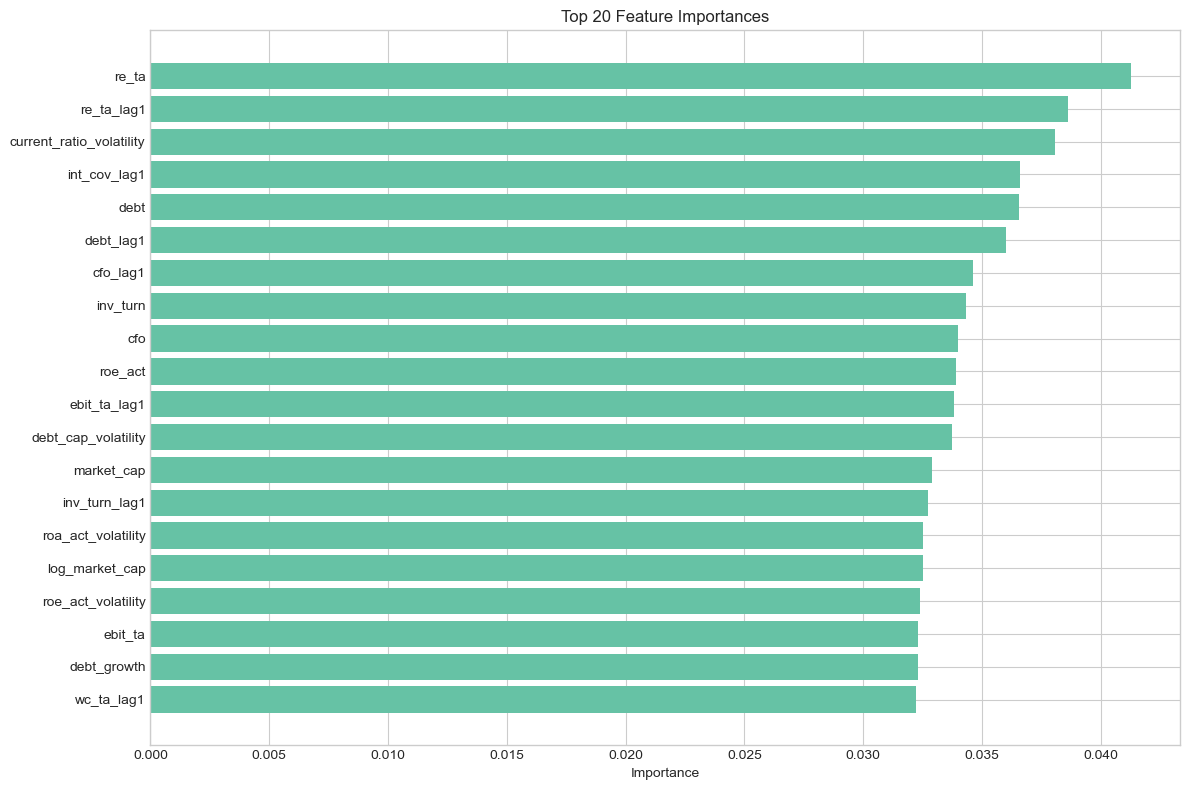

Model artifacts saved with prefix: financial_distress_predictor
=== ANALYSIS COMPLETE ===
Best model: random_forest with ROC AUC: 0.831


In [50]:
# --- FINAL MODEL SELECTION AND DEPLOYMENT PREPARATION ---
def prepare_final_model(X, y, model, feature_names=None):
    """
    Prepare final model on all available data for deployment
    
    Parameters:
    X: Feature matrix (numpy array or pandas DataFrame)
    y: Target variable
    model: The model to train
    feature_names: List of feature names (required if X is a numpy array)
    """
    # Retrain the model on all data
    final_model = model.__class__(**model.get_params())
    final_model.fit(X, y)
    
    # Create feature importance dataframe if available
    if hasattr(final_model, 'feature_importances_'):
        # Get feature names
        if feature_names is not None:
            features = feature_names
        elif hasattr(X, 'columns'):
            features = X.columns
        else:
            print("Warning: No feature names available. Using indices.")
            features = [f'feature_{i}' for i in range(X.shape[1])]
        
        feature_importance = pd.DataFrame({
            'feature': features,
            'importance': final_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Top 20 most important features:")
        display(feature_importance.head(20))
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        plt.barh(feature_importance['feature'][:20][::-1], 
                feature_importance['importance'][:20][::-1])
        plt.xlabel('Importance')
        plt.title('Top 20 Feature Importances')
        plt.tight_layout()
        plt.show()
    
    return final_model

# --- SAVE RESULTS AND MODEL ---
import joblib
import json

def save_model_artifacts(model, scaler=None, selector=None, feature_names=None, 
                        results=None, model_name="financial_distress_predictor"):
    """
    Save all model artifacts for deployment
    """
    # Save final model
    joblib.dump(model, f'{model_name}.pkl')
    
    if scaler is not None:
        joblib.dump(scaler, f'{model_name}_scaler.pkl')
    
    if selector is not None:
        joblib.dump(selector, f'{model_name}_selector.pkl')
    
    # Save feature names
    if feature_names is not None:
        with open(f'{model_name}_feature_names.json', 'w') as f:
            json.dump(list(feature_names), f)
    
    # Save performance results
    if results is not None:
        if isinstance(results, dict):
            results_df = pd.DataFrame.from_dict(results, orient='index')
        else:
            results_df = results
        results_df.to_csv(f'{model_name}_performance_results.csv')
    
    print(f"Model artifacts saved with prefix: {model_name}")

# --- COMPLETE WORKFLOW EXAMPLE ---
# Assuming you have already trained models and selected the best one
if 'trained_models' in locals() and 'results' in locals():
    # Get the best model name from results
    best_model_name = results.index[0]  # Assuming results is a DataFrame sorted by performance
    best_model = trained_models[best_model_name]
    
    print(f"Selected best model: {best_model_name}")
    print(f"Performance: ROC AUC = {results.loc[best_model_name, 'roc_auc']:.3f}")
    
    # Prepare final model on all data (train + test)
    # Check if X_train and X_test are DataFrames or arrays
    if hasattr(X_train, 'columns'):
        # They are DataFrames
        X_all = pd.concat([X_train, X_test])
        y_all = pd.concat([y_train, y_test])
        feature_names = X_all.columns
    else:
        # They are numpy arrays
        X_all = np.vstack([X_train, X_test])
        y_all = np.concatenate([y_train, y_test])
        # You need to provide feature names if you want to see feature importance
        feature_names = None  # Or provide a list of feature names if you have them
    
    final_model = prepare_final_model(X_all, y_all, best_model, feature_names=feature_names)
    
    # Save all artifacts
    save_model_artifacts(
        model=final_model,
        scaler=scaler if 'scaler' in locals() else None,
        selector=selector if 'selector' in locals() else None,
        feature_names=feature_names,
        results=results
    )
    
    print("=== ANALYSIS COMPLETE ===")
    print(f"Best model: {best_model_name} with ROC AUC: {results.loc[best_model_name, 'roc_auc']:.3f}")
else:
    print("Error: trained_models or results not found. Please run the training code first.")